<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Александр, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />    
Несмотря на то, что проект не такой уж и простой как с позиции кода, так и в понимании процессов - <br />тебе удалось сдать его вовремя, это большой плюс для всех нас, спасибо:)<br />
<br />
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.

# Исследовательский анализ данных промышленной задачи и построение модели, которая предскажет температуру стали

## Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Обозначенная метрика и критерии оценки

Целевой признак: последняя измеренная температура.

Метрика: MAE

Критерии оценки:

    MAE > 8.7 — 0 sp
    7.6 < MAE ≤ 8.7 — 4 sp
    6.8 < MAE ≤ 7.6 — 4.5 sp
    6.3 < MAE ≤ 6.8 — 5 sp
    6.0 < MAE ≤ 6.3 — 5.5 sp
    MAE ≤ 6.0 — 6 sp

## План работы

    1) Ознакомиться с производственными особенностями и определить наибольшие факторы влияния на температуру плавления
    2) Произвести изучение и предобработку полученных данных
    3) Выявить аномалии и устранить их
    4) Выявить дополнительные целевые признаки (помимо данных о результатах измерения температуры) и дополнить ими сводную таблицу
    5) Обучить регресионную модель
    6) Провести сравнение с константной моделью
    7) Описать итоги

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

### Изучение данных об электродах - data_arc.csv

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


По условию задачи мы знаем, что во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки. 

Из первых данных мы видим, что нагрев и его замеры происходит в несколько итераций, о чем свидетельствует key.

Посмотрим как распределяются значения Активной и Реактивной мощности

In [4]:
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

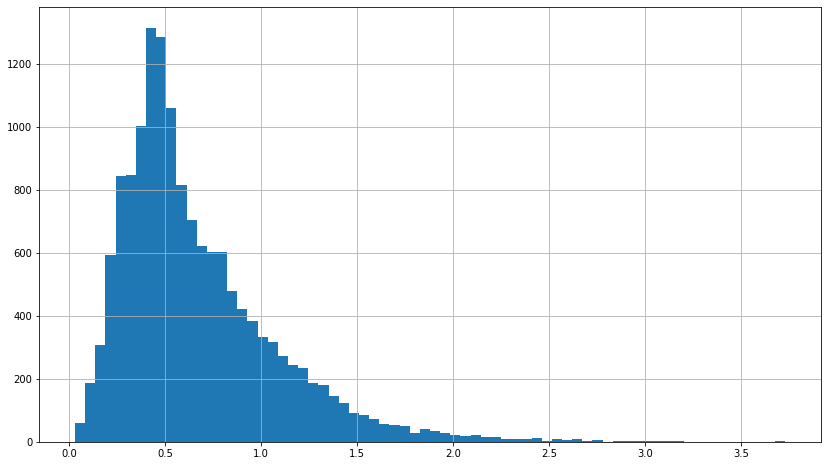

In [5]:
data_arc['Активная мощность'].hist(figsize = (14,8), bins = 70)

In [6]:
data_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

По минимальному значению сразу видно, что на данных собираемых по реактивной мощности есть выброс. Реактивная мощность может быть как положительной величиной (если нагрузка имеет активно-индуктивный характер), так и отрицательной (если нагрузка имеет активно-ёмкостный характер), однако в нашем случае это единичное значение, к тому же больше похожее на ошибку (из-за величины отрицательного значения), которое можно сразу отбросить.

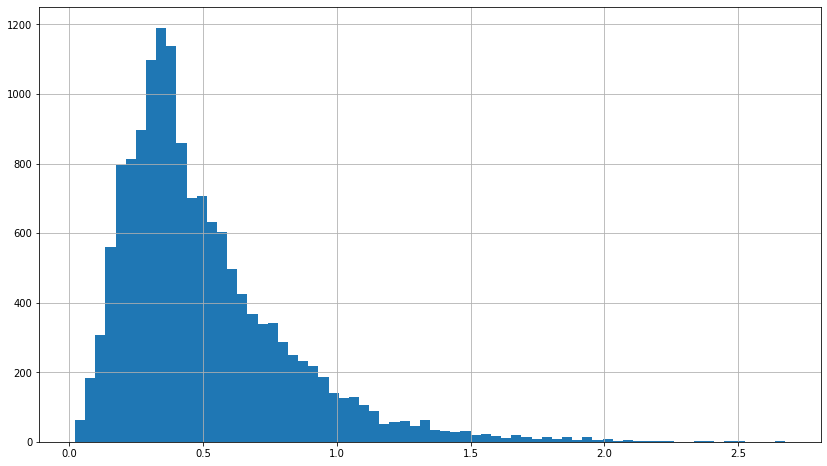

In [7]:
data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] > 0].hist(figsize = (14,8), bins = 70)

#### Вывод по изучению данных об электродах


    1) Начало нагрева дугой и Конец нагрева дугой имеют тип  object - его стоит сменить на DateTime
    2) Поскольку нагрев происходит в несколько итераций, можно вычислить суммарную длительность нагрева электродами
    3) По имеющимся данным, мы так же можем вычислить полную мощность с использованием активной и реактивной мощности, а затем проверить на ошибки в данных.
    4) В реактивной мощности сразу замечен выброс, который можно очистить, поскольку он один 
    5) По уникальным значениям key можно определить суммарную затраченную энергию на все итерации

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ок

In [8]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


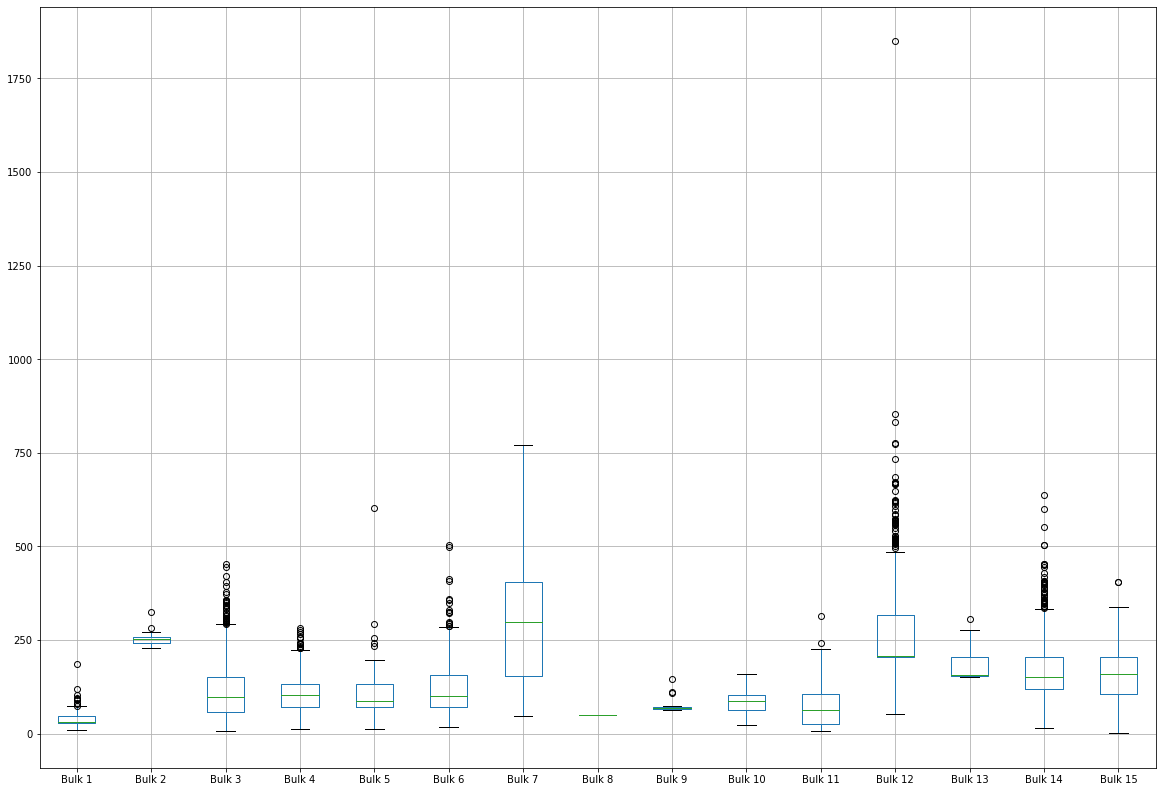

In [10]:
data_bulk_boxplot = data_bulk.drop('key', 1)
data_bulk_boxplot.boxplot(figsize = (20,14))


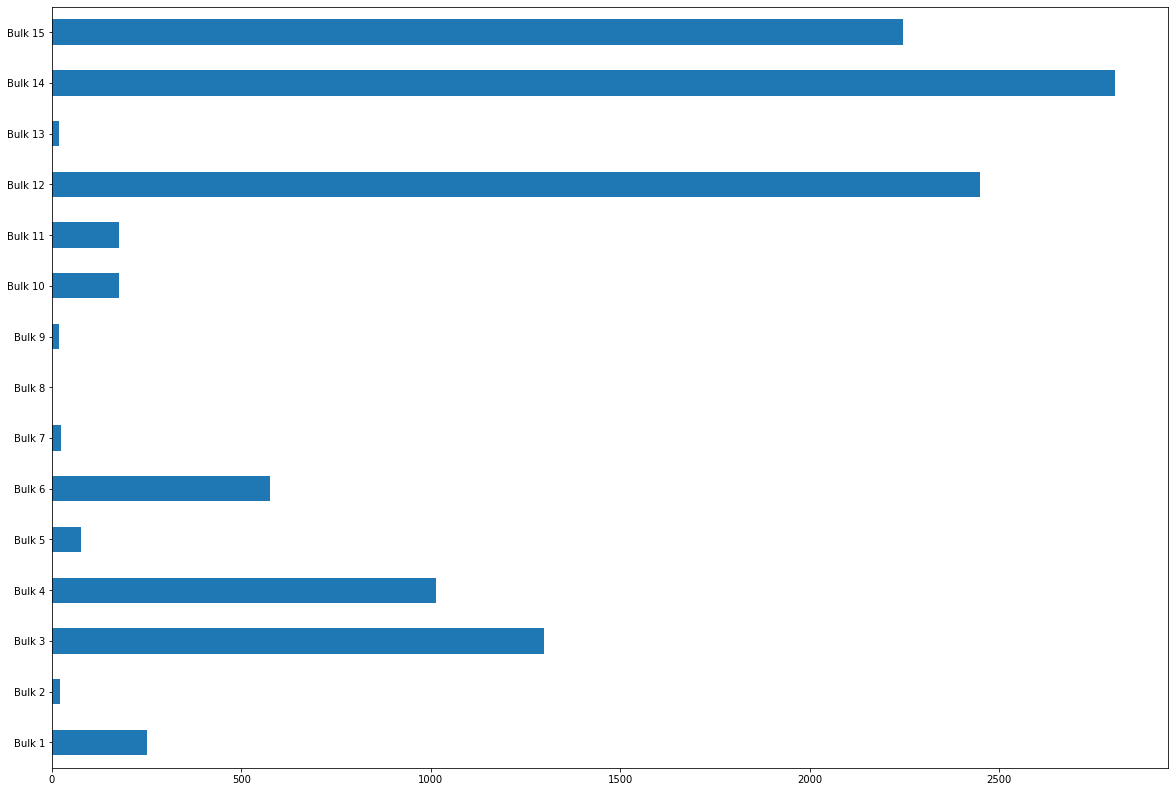

In [11]:
data_bulk_boxplot.count().plot(kind='barh', figsize=(20,14));

#### Изучение данных о подаче сыпучих материалов по времени - data_bulk_time.csv

In [12]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [13]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


#### Вывод по изучению данных о подаче сыпучих материалов

    1) Значения подачи по времени требуют преобразования в формате datetime
    2) Множество элентов в нулевых значениях, за счет редкого использования в подаче примесей

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>аналогично.

### Изучение данных о проволочных материалах - data_wire.csv

In [14]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [15]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [17]:
print(data_wire['key'].unique())
data_wire.info()

[   1    2    3 ... 3239 3240 3241]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Изучение данных о проволочных материалах по времени - data_wire_time.csv

In [18]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [19]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Изучение данных о продувке сплава газом - data_gas.csv

In [20]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [23]:
data_gas['Газ 1'].isnull().sum()

0

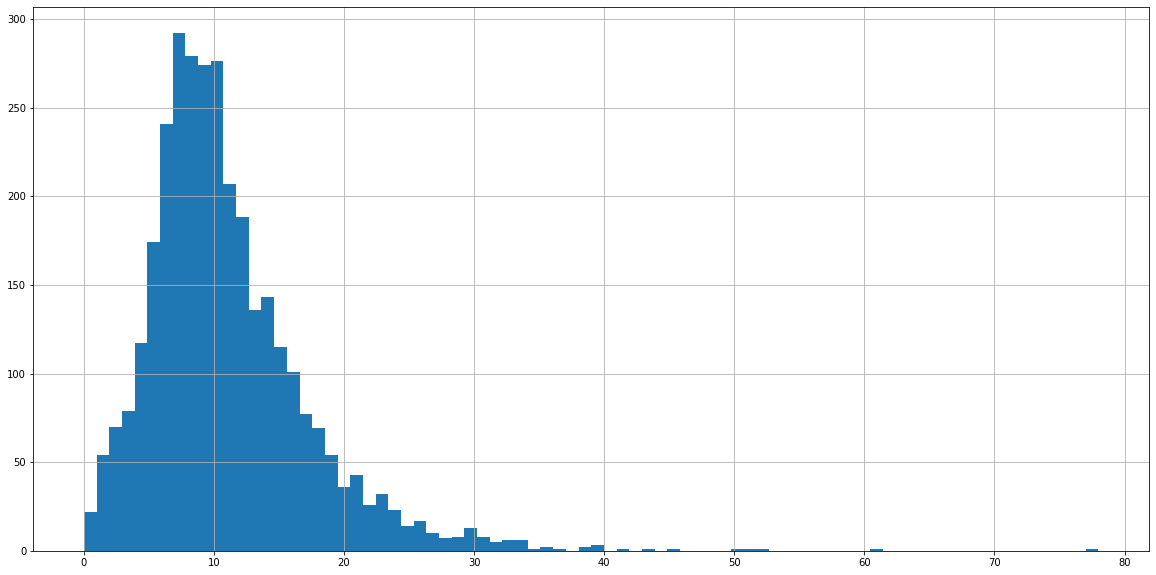

In [24]:
data_gas.groupby('key')['Газ 1'].sum().hist(bins = 80, figsize = (20,10))

In [25]:
data_gas['key'].value_counts()

2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049    1
Name: key, Length: 3239, dtype: int64

In [26]:
data_gas.columns = ['key','Объем газа']

По гистограмме видно, что объемы газа в большей степени находятся в районе 10. Весь газ распределен на уникальные итерации.

### Изучение данных результатов измерения температуры - data_temp.csv

In [27]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Количество данных по температуре меньше, чем количество времени замера, проверим на пустоты.

In [28]:
data_temp['Температура'].unique()

array([1571., 1604., 1618., 1601., 1613., 1581., 1577., 1589., 1608.,
       1602., 1596., 1597., 1598., 1599., 1623., 1625., 1576., 1543.,
       1600., 1586., 1582., 1595., 1587., 1592., 1574., 1580., 1585.,
       1588., 1593., 1616., 1583., 1606., 1584., 1591., 1610., 1621.,
       1615., 1619., 1605., 1607., 1611., 1590., 1609., 1603., 1579.,
       1626., 1617., 1560., 1563., 1594., 1612., 1578., 1566., 1572.,
       1575., 1614., 1567., 1562., 1564., 1636., 1570., 1538., 1556.,
       1629., 1542., 1565., 1573., 1660., 1690., 1652., 1666., 1667.,
       1669., 1668., 1642., 1658., 1671., 1665., 1674., 1676., 1630.,
       1654., 1655., 1663., 1635., 1656., 1631., 1653., 1648., 1659.,
       1641., 1645., 1675., 1569., 1559., 1558., 1548., 1541., 1553.,
       1662., 1679., 1637., 1622., 1644., 1649., 1643., 1526., 1550.,
       1561., 1557., 1544., 1568., 1620., 1647., 1638., 1547., 1627.,
       1628., 1551., 1549., 1624., 1650., 1684., 1634., 1646., 1651.,
       1633., 1640.,

In [29]:
data_temp['Температура'].isna().sum()

2901

Количество пустых значений достаточно много, их будет необходимо обработать, но для начала посмотрим, сколько из них относится к необходимым нам данным.

In [30]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [31]:
data_temp[data_temp['key'] == 1].head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [32]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [33]:
data_temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

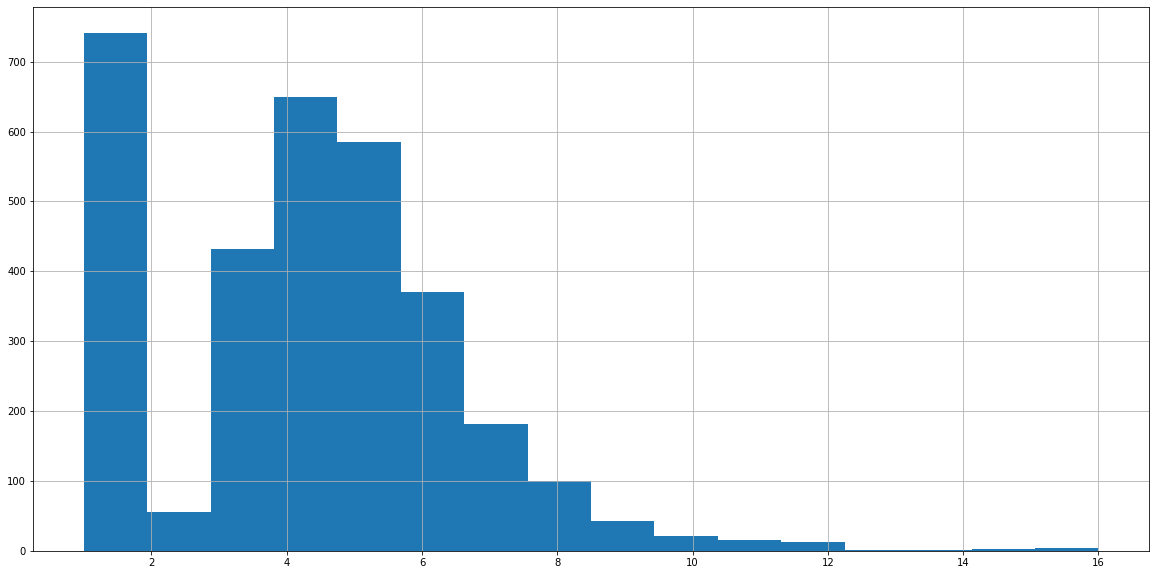

In [34]:
data_temp.groupby('key')['Температура'].count().hist( figsize = (20,10), bins = 16)

In [35]:
print((data_temp.groupby('key')['Время замера'].count() == 1 ).sum())

2


На гистограмме видно, что более 700 партий имеют два и менее замеров.Это может негативно сказываться при обучении модели, поскольку основная масса находится от 3 до 6 и поэтому потребуется тестирование изменений качества модели и, возможно, потребуется удалить значения с 2 замерами.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>да, это важный момент проекта.

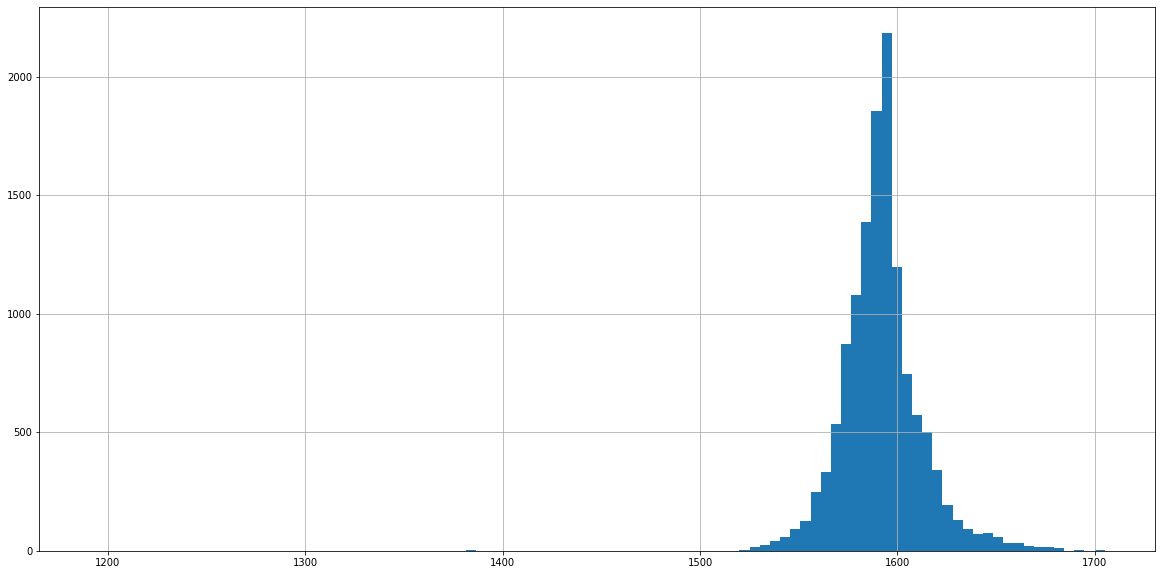

In [36]:
data_temp['Температура'].hist(bins = 100, figsize = (20,10))

#### Вывод по изучению данных результатов измерения температуры

    1) При просмотре уникальных подсчетов видно, что пристуствуют разовые замеры, которые следует удалить
    2) Столбец "Время замера" необходимо перевести в формат datetime
    3) Поскольку нам необходимо делать просчет по оптимальной температуре плавки на финальном замере, то начальные замеры пойдут в признаки.
    4) Температуру с float лучше перевести в int
    5) По данным начальных и финальных замеров можно вычислить общее время плавления
    6) Удалить или заменить пустые значения температуры

Посмотрим уникальные значения партий в таблицах:

In [37]:
print('данные об электродах -', len(data_arc['key'].unique()))
print('данные о подаче сыпучих материалов (объём) -', len(data_bulk['key'].unique()))
print('данные о подаче сыпучих материалов (время) -', len(data_bulk_time['key'].unique()))
print('данные о продувке сплава газом -', len(data_gas['key'].unique()))
print('результаты измерения температуры -', len(data_temp['key'].unique()))
print('данные о проволочных материалах (объём) -', len(data_wire['key'].unique()))
print('данные о проволочных материалах (время) -', len(data_wire_time['key'].unique()))

данные об электродах - 3214
данные о подаче сыпучих материалов (объём) - 3129
данные о подаче сыпучих материалов (время) - 3129
данные о продувке сплава газом - 3239
результаты измерения температуры - 3216
данные о проволочных материалах (объём) - 3081
данные о проволочных материалах (время) - 3081


Данные по партиям разнятся. Это может говорить о том, что некоторые этапы не использовались при обработке стали или есть лишние показатели.

### Общий итог по изучению данных

По итогам изучения данных были выявлены следующие проблемы, требующие проработки:

        1) Стоит перевести форматы некоторых столбцов , например, из float в int или из object в datetime
        2) Данные по партиям разнятся. Это может говорить о том, что некоторые этапы не использовались при обработке стали или есть лишние показатели.
        3) Присутствуют аномальные значения во фреймах, которые стоит удалить или проверить, чтобы улучишть исходные данные подаваемые для обучения.
        4) Следует заполнить значения NaN на другие, например 0.

Исходя из данных всех таблиц выше и описания задачи мы видим, что фрейм data_temp.csv является основным признаком и модели потребуется больше всевозможных данных по разным этапам, чтобы формировать более точные прогнозы. Для этого необходимо сформировать итоговую таблицу со всеми признакми, предварительно создав их в каждом из доступных фреймов, например, посчитать длительности этапов или используемую полную мощность. 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>отлично, данные на базе и есть первичный аналитический осмотр))

## Материалы, найденные для ознакомления с темой и рекомандации после встречи с ТЛ: 
    

    1) http://electrokaprizam.net/content/35-chto-takoe-kva-kwt-kvar
    2) https://patonpublishinghouse.com/sem/pdf/2016/pdfarticles/01/10.pdf
    3) https://pstu.ru/files/2/file/kafedra/mtf/kafedry/MTO/MU/Metallurgicheskie_tehnologii.pdf
    4) https://edrid.ru/rid/216.013.20fa.html
    5) https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf
    6) http://khomovelectro.kz/article/aktivnaya-reaktivnaya-i-polnaya-kazhushchayasya-moshchnosti.html

В результате общения с ТЛ были определены следующие технологические особенности производства:

    1) Важно сократить "лестницу" изменения температур
    2) Прогнозируем финальную температуру плавления
    3) Если в рамках партии только одно изменение температуры, то её отбрасываем. Во всех остальных партиях берем за целевой признак финальное изменение температуры.
    4) Данные о нагреве использовать не стоит, кроме суммарной. Аналогично и с временем подачи сыпучих материалов.
    5) Значения по примесях можно суммировать
    6) Стоит посчитать полную мощность и заменить два параметра на один.
    7) Данные агрегируем, а потом проверяем на их эффективность в модели

А так же определены обязательные этапы при формировании кода и построении отчета:

    1) Ответы на приведенные вопросы
    2) Подробное описание преобразования данных
    3) Определение Feature importances 

## Предвариательная обработка данных

### Обработка пропусков

In [38]:
# Заполним nan значения на 0, чтобы в дальнейшем сделать после просчет сумм
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

 <div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
 👍

In [39]:
#удалим пустые значения из ключевых данных по температуре
data_temp = data_temp.dropna()

In [40]:
print((data_temp.groupby('key')['Время замера'].count() == 1 ).sum())

741


741 строка имеет всего лишь один замер. Их необходимо удалить, сделаем это после разделения данных по времени.

 <div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
 👍 👍

### Изменение форматов данных

In [41]:
data_bulk_time_columns = ['Bulk 1' ,'Bulk 2','Bulk 3','Bulk 4',
                          'Bulk 5','Bulk 6','Bulk 7','Bulk 8',
                          'Bulk 9','Bulk 10','Bulk 11','Bulk 12',
                          'Bulk 13','Bulk 14','Bulk 15']
data_bulk_time[data_bulk_time_columns] = data_bulk_time[data_bulk_time_columns].astype('datetime64')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [42]:
data_wire_time_columns = ['Wire 1',	'Wire 2',	'Wire 3',	'Wire 4',
                          'Wire 5',	'Wire 6',	'Wire 7',	'Wire 8',	'Wire 9']
data_wire_time[data_wire_time_columns] = data_wire_time[data_wire_time_columns].astype('datetime64')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [43]:
data_temp['Температура'] = data_temp['Температура'].astype('int')
data_temp['Время замера'] = data_temp['Время замера'].astype('datetime64')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null datetime64[ns]
Температура     13006 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 406.4 KB


### Преобразование существущих данных и создание новых значений

#### Вычисление полной мощности

In [44]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 +  data_arc['Реактивная мощность']**2)**0.5

In [45]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


In [46]:
#произведем подсчет суммарной мощности, для каждого нагрева
data_arc_new = data_arc[['key', 'Полная мощность']]

In [47]:
data_arc_new = data_arc_new.groupby('key')['Полная мощность'].sum()

In [48]:
data_arc_new.head()

key
1    5.826395
2    3.649216
3    2.989534
4    3.814962
5    4.035758
Name: Полная мощность, dtype: float64

 <div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
понятно.

#### Вычисление суммарных значений примесей 

In [49]:
data_wire.set_index('key', inplace=True)

In [50]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(9)
memory usage: 240.7 KB


In [51]:
data_wire['wire_sum'] = data_wire.sum(axis=1)

In [52]:
data_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum
key,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [53]:
data_bulk.set_index('key', inplace=True)

In [54]:
data_bulk['bulk_sum'] = data_bulk.sum(axis=1)

In [55]:
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


#### Вычисление начала и конца времени замера температуры

In [56]:
data_temp_min = data_temp.loc[data_temp.groupby('key')['Время замера'].idxmin()].copy()
data_temp_max = data_temp.loc[data_temp.groupby('key')['Время замера'].idxmax()].copy()

In [57]:
data_temp_new = data_temp_min.merge(data_temp_max, on='key')

In [58]:
data_temp_new.head()

,key,Время замера_x,Температура_x,Время замера_y,Температура_y
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602


In [59]:
data_temp_new.columns=['key', 'Время первого замера','Начальная температура','Время последнего замера','Финальная температура']

In [60]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
key                        3216 non-null int64
Время первого замера       3216 non-null datetime64[ns]
Начальная температура      3216 non-null int64
Время последнего замера    3216 non-null datetime64[ns]
Финальная температура      3216 non-null int64
dtypes: datetime64[ns](2), int64(3)
memory usage: 150.8 KB


In [61]:
data_temp_last = data_temp_new.loc[data_temp_new['Время первого замера'] < data_temp_new['Время последнего замера']]

In [62]:
data_temp_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 5 columns):
key                        2475 non-null int64
Время первого замера       2475 non-null datetime64[ns]
Начальная температура      2475 non-null int64
Время последнего замера    2475 non-null datetime64[ns]
Финальная температура      2475 non-null int64
dtypes: datetime64[ns](2), int64(3)
memory usage: 116.0 KB


In [63]:
data_temp_last['Время плавления'] = (data_temp_last['Время первого замера'] - data_temp_last['Время последнего замера']).apply(lambda x: x.seconds)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
data_temp_last.head()

,key,Время первого замера,Начальная температура,Время последнего замера,Финальная температура,Время плавления
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,85539
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,85095
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,85100
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,86012
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,85638


 <div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
чётко. Единственное - время плавления в виде числа, видимо... сложно воспринимать будет всем)

## Формирование единого дата фрейма, обучающей и тестовой выборки

Поскольку в data_temp_last находится целевой признак, то все остальные значения будем присоединять к нему по ключу "key"

In [65]:
data =  data_temp_last.merge(data_gas, on='key', how='left')

In [66]:
data.head()

,key,Время первого замера,Начальная температура,Время последнего замера,Финальная температура,Время плавления,Объем газа
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,85539,29.749986
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,85095,12.555561
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,85100,28.554793
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,86012,18.841219
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,85638,5.413692


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 7 columns):
key                        2475 non-null int64
Время первого замера       2475 non-null datetime64[ns]
Начальная температура      2475 non-null int64
Время последнего замера    2475 non-null datetime64[ns]
Финальная температура      2475 non-null int64
Время плавления            2475 non-null int64
Объем газа                 2473 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4)
memory usage: 154.7 KB


In [68]:
data_arc_new.reset_index()

,key,Полная мощность
0,1,5.826395
1,2,3.649216
2,3,2.989534
3,4,3.814962
4,5,4.035758
...,...,...
3209,3237,4.844982
3210,3238,2.696542
3211,3239,5.611883
3212,3240,3.891856


In [69]:
data =  data.merge(data_arc_new, on='key', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 8 columns):
key                        2475 non-null int64
Время первого замера       2475 non-null datetime64[ns]
Начальная температура      2475 non-null int64
Время последнего замера    2475 non-null datetime64[ns]
Финальная температура      2475 non-null int64
Время плавления            2475 non-null int64
Объем газа                 2473 non-null float64
Полная мощность            2475 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 174.0 KB


In [70]:
data_wire.reset_index()
data =  data.merge(data_wire['wire_sum'], on='key', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 9 columns):
key                        2475 non-null int64
Время первого замера       2475 non-null datetime64[ns]
Начальная температура      2475 non-null int64
Время последнего замера    2475 non-null datetime64[ns]
Финальная температура      2475 non-null int64
Время плавления            2475 non-null int64
Объем газа                 2473 non-null float64
Полная мощность            2475 non-null float64
wire_sum                   2372 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(4)
memory usage: 193.4 KB


In [71]:
data_bulk.reset_index()
data =  data.merge(data_bulk['bulk_sum'], on='key', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 10 columns):
key                        2475 non-null int64
Время первого замера       2475 non-null datetime64[ns]
Начальная температура      2475 non-null int64
Время последнего замера    2475 non-null datetime64[ns]
Финальная температура      2475 non-null int64
Время плавления            2475 non-null int64
Объем газа                 2473 non-null float64
Полная мощность            2475 non-null float64
wire_sum                   2372 non-null float64
bulk_sum                   2407 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 212.7 KB


In [72]:
data.columns = ['key','Время первого замера','Начальная температура','Время последнего замера','Финальная температура',
                'Время плавления', 'Объем газа', 'Полная мощность', 'Объем проволочных материалов', 'Объем сыпучих материалов']

In [73]:
data.isnull().sum()

key                               0
Время первого замера              0
Начальная температура             0
Время последнего замера           0
Финальная температура             0
Время плавления                   0
Объем газа                        2
Полная мощность                   0
Объем проволочных материалов    103
Объем сыпучих материалов         68
dtype: int64

При обсуждении NaN c ТЛ было определено, что эти данные в примесях можно заменить на 0. Т.е. добавления примесей не было. Поэтому заменим все получившиеся пропуски еще раз на 0.

In [74]:
data.fillna(0, inplace=True)

In [75]:
data.isnull().sum()

key                             0
Время первого замера            0
Начальная температура           0
Время последнего замера         0
Финальная температура           0
Время плавления                 0
Объем газа                      0
Полная мощность                 0
Объем проволочных материалов    0
Объем сыпучих материалов        0
dtype: int64

In [76]:
data.head()

,key,Время первого замера,Начальная температура,Время последнего замера,Финальная температура,Время плавления,Объем газа,Полная мощность,Объем проволочных материалов,Объем сыпучих материалов
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,85539,29.749986,5.826395,60.059998,553.0
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,85095,12.555561,3.649216,96.052315,582.0
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,85100,28.554793,2.989534,91.160157,544.0
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,86012,18.841219,3.814962,89.063515,595.0
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,85638,5.413692,4.035758,98.352796,584.0


Чтобы избавиться от ошибки "Do not support non-ASCII characters in feature name." переведем все столбцы в латиницу.

In [77]:
data.columns = ['key','time_start','temp_start','time_finish',
                'temp_finish','melting_time','gas_volume','full_power','wire_materials','bulk_materials']

Разобьем полученные значения на обучающую и тестовую выборку. 

В features попадут:

    1) Начальная температура
    2) Время плавления
    3) Объем газа
    4) Суммарная полная мощность
    5) Суммарный объем сыпучих материалов
    6) Суммарный объем проволочных материалов
   
В target, исходя из цели берем:
    
    1)Финальная температура
    
    


In [84]:
data[['temp_start','melting_time','gas_volume',
                                          'full_power','wire_materials','bulk_materials']]

,temp_start,melting_time,gas_volume,full_power,wire_materials,bulk_materials
0,1571,85539,29.749986,5.826395,60.059998,553.0
1,1581,85095,12.555561,3.649216,96.052315,582.0
2,1596,85100,28.554793,2.989534,91.160157,544.0
3,1601,86012,18.841219,3.814962,89.063515,595.0
4,1576,85638,5.413692,4.035758,98.352796,584.0
...,...,...,...,...,...,...
2470,1570,85263,7.125735,3.986869,89.150879,719.0
2471,1554,84782,9.412616,5.057033,114.179527,796.0
2472,1571,85683,6.271699,2.885017,103.134723,665.0
2473,1591,85098,14.953657,4.143749,118.110717,733.0


In [78]:
features_train, features_test, target_train, target_test  = train_test_split(
                                    data[['temp_start','melting_time','gas_volume',
                                          'full_power','wire_materials','bulk_materials']], 
                                    data['temp_finish'],
                                    test_size=0.2, random_state = 12345)

In [79]:
#проверим размерность
print( features_train.shape, target_train.shape, features_test.shape,  target_test.shape )

(1980, 6) (1980,) (495, 6) (495,)


Выборки для обучения моделей сформированы. Можно приступать к её реализации. Исходя из встречи с ТЛ определили предпочитаемые для обучения модели:
    
    1) RandomForestRegressor
    2) LGBM
    3) CatBoostRegressor
    
    
И естественно сделаем проверку с Dummy моделью.
    

 <div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
таааак, с табличкой всё в тему вышло). Важно, что удалил лишние факторы. Как и писал - со значением температуры только сложнова-то воспринимать.

## Обучение и тестирование моделей

### Dummy

In [80]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train, target_train)
dummy_model_predict_train = dummy_model.predict(features_train)
dummy_model_predict_test = dummy_model.predict(features_test)

dummy_mae_train = mean_absolute_error(target_train, dummy_model_predict_train)
dummy_mae_test = mean_absolute_error(target_test, dummy_model_predict_test)

print('Качество модели Dummy на тренировочной выборке: {:.2f}'.format(dummy_mae_train))
print('Качество модели Dummy на тестовой выборке: {:.2f}'.format(dummy_mae_test))

Качество модели Dummy на тренировочной выборке: 9.96
Качество модели Dummy на тестовой выборке: 9.64


 <div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ориентир задан.

### RandomForestRegressor

In [81]:
%%time
RF = RandomForestRegressor(random_state = 12345)

params_RF = {    
    'max_depth': range(14, 20, 2),
    'n_estimators': range(140, 260, 10),
    'min_samples_leaf' : [2]   
}

model_RandomForest = GridSearchCV(RF, params_RF, 
                                  scoring = 'neg_mean_absolute_error',
                                  cv=5, return_train_score=True, verbose=1,n_jobs = 10)

model_RandomForest.fit(features_train, target_train)      
print('Лучшие подобранные параметры для модели RandomForestRegressor:', model_RandomForest.best_params_)
print()

RandomForest_mae_train = model_RandomForest.best_score_  * -1
RandomForest_mae_test = mean_absolute_error(target_test, model_RandomForest.predict(features_test))

print('Качество модели RandomForest на тренировочной выборке: {:.2f}'.format(RandomForest_mae_train))
print('Качество модели RandomForest на тестовой выборке: {:.2f}'.format(RandomForest_mae_test))
print()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:  7.2min finished


Лучшие подобранные параметры для модели RandomForestRegressor: {'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 250}

Качество модели RandomForest на тренировочной выборке: 6.39
Качество модели RandomForest на тестовой выборке: 6.36

CPU times: user 2.66 s, sys: 161 ms, total: 2.82 s
Wall time: 7min 16s


### LGBMRegressor

С целью сокращения времени обучения модели, были просчитаны лучшие параметры и зафиксированы:

      'boosting_type': 'gbdt',
     'learning_rate': 0.06,
     'max_bin': 100,
     'max_depth': 14,
     'min_data_in_leaf': 12,
     'num_leaves': 37,
     'objective': 'regression'

In [82]:
#lgbm = LGBMRegressor(random_state=12345)
#params_lgbm = { 
#    'objective': ['regression'],
#    'boosting_type': ['gbdt'],
#    'max_depth': range(10, 20, 2),    
#    'num_leaves': range(20, 41, 1),
#    'min_data_in_leaf': range(12, 15, 1),   
#    'max_bin': range(80, 121, 10),
#    'learning_rate': [0.01, 0.02, 0.05, 0.06],
#}    
#
#model_lgbm = GridSearchCV(lgbm, params_lgbm, cv=5, scoring='neg_mean_absolute_error',
#                          verbose=1, n_jobs=10)                 
#model_lgbm.fit(features_train, target_train)
#print('Лушчие параметры для LGBMRegressor:')
#display(model_lgbm.best_params_, model_lgbm.best_score_) 

In [83]:
lgbm = LGBMRegressor(random_state=12345)
params_lgbm = { 
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'max_depth': [14],    
    'num_leaves': [37],
    'min_data_in_leaf': [12],   
    'max_bin': [100],
    'learning_rate': [0.06],
}    

model_lgbm = GridSearchCV(lgbm, params_lgbm, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=10, refit=True)                 
model_lgbm.fit(features_train, target_train)
#print('Лучшие параметры для LGBMRegressor:')
#display(model_lgbm.best_params_, model_lgbm.best_score_) 
print()

LightGBM_mae_train = model_lgbm.best_score_ * -1
LightGBM_mae_test = mean_absolute_error(target_test, model_lgbm.predict(features_test))

print('Качество модели LightGBM на тренировочной выборке: {:.2f}'.format(LightGBM_mae_train))
print('Качество модели LightGBM на тестовой выборке: {:.2f}'.format(LightGBM_mae_test))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.0s finished



Качество модели LightGBM на тренировочной выборке: 6.43
Качество модели LightGBM на тестовой выборке: 6.31


### CatBoostRegressor

In [84]:
%%time

CBR = CatBoostRegressor(verbose=False, random_state=12345)

cross_val_catboost = (cross_val_score(CBR, features_train, target_train,cv=5, scoring='neg_mean_absolute_error').mean() * -1)

model_catboost = CatBoostRegressor(verbose=False)
params_catboost = CatBoostRegressor(verbose=False, random_state=12345).fit(features_train, target_train).get_all_params()

model_catboost.set_params(**params_catboost)
model_catboost.fit(features_train, target_train)
target_predict = model_catboost.predict(features_test)
mae_test_cbr= mean_absolute_error(target_predict, target_test)
print()
print('Качество CatBoostRegressor модели на тренировочной выборке: {:.2f}'.format(cross_val_catboost))
print('Качество CatBoostRegressor модели на тестовой выборке: {:.2f}'.format(mae_test_cbr))
print()


Качество CatBoostRegressor модели на тренировочной выборке: 6.20
Качество CatBoostRegressor модели на тестовой выборке: 6.36

CPU times: user 56.4 s, sys: 5.03 s, total: 1min 1s
Wall time: 1min 7s


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

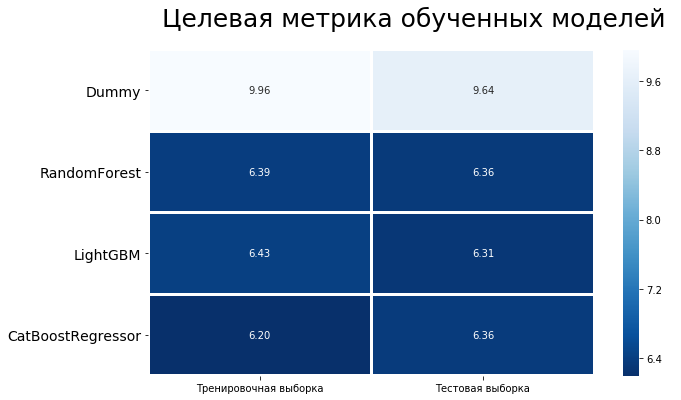

In [85]:
all_metrics = {"Тренировочная выборка":pd.Series([dummy_mae_train, RandomForest_mae_train, LightGBM_mae_train, cross_val_catboost],
                                                 index=['Dummy', 'RandomForest', 'LightGBM', 'CatBoostRegressor']),
              "Тестовая выборка":pd.Series([dummy_mae_test, RandomForest_mae_test, LightGBM_mae_test, mae_test_cbr], index=['Dummy', 'RandomForest', 'LightGBM', 'CatBoostRegressor'])}

data_metrics = pd.DataFrame(all_metrics)

plt.figure(figsize=(10,6))
sns.heatmap(data_metrics,  annot=data_metrics, fmt='.2f', linewidths=2 , cmap="Blues_r")
plt.suptitle('Целевая метрика обученных моделей ', fontsize=25)
plt.yticks( rotation=0, fontsize=14)

## Сравнение значимости признаков в моделях

Сравним все построенные модели, приведя их к единому формату

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

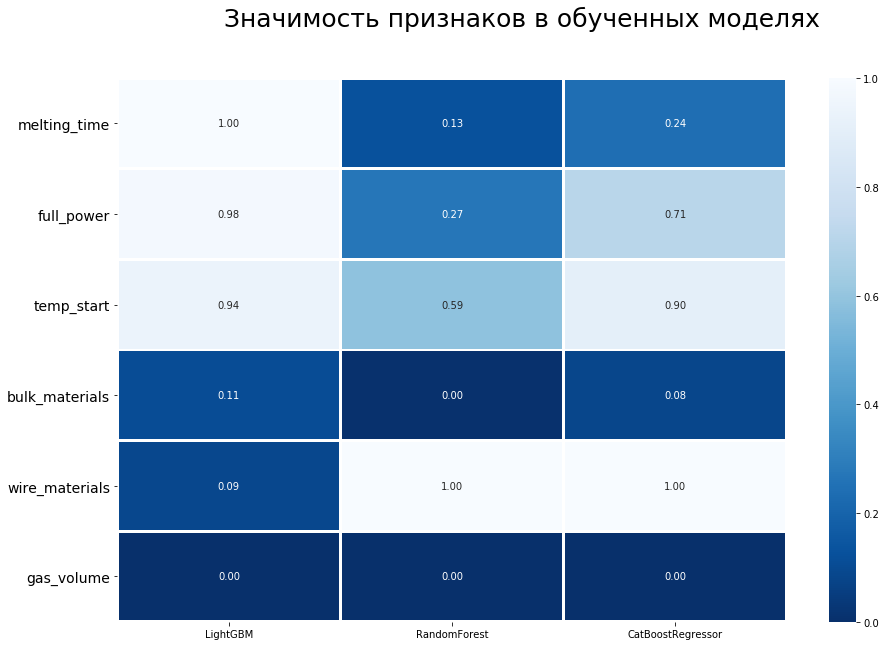

In [86]:
feature_importances = pd.DataFrame(index=features_train.columns,
                                     data={
                                    'LightGBM': model_lgbm.best_estimator_.feature_importances_,
                                    'RandomForest':   model_RandomForest.best_estimator_.feature_importances_,
                                    'CatBoostRegressor':   model_catboost.get_feature_importance(type=catboost.EFstrType.FeatureImportance)
                                     })
                                           
feature_importances = feature_importances.sort_values(by='LightGBM', ascending=False)
feature_importances[:] = MinMaxScaler().fit_transform(feature_importances)

plt.figure(figsize=(15,10))
sns.heatmap(feature_importances,  annot=feature_importances, fmt='.2f', linewidths=2 , cmap="Blues_r")
plt.suptitle('Значимость признаков в обученных моделях', fontsize=25)
plt.yticks( rotation=0, fontsize=14)


По степени влияния признаков видно, что объемы газа и сыпучие материалы меньше всего влияют на качество модели. Поэтому для тестирования мы создадим новый набор признаков и обучим на них модели снова.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>КЛАССССНО оформил!! хорошо, что используешь этот инструмент. На начальном этапе мы можем нагенерить множество разных фич, в том чтисле и лишних. И вот этот инструмент, вкупе с анализом мультиколлинеарности позволяет избавляться от "балласта")

## Обучение моделей с учетом корректировок признаков в выборках

In [87]:
features_train_2, features_test_2, target_train_2, target_test_2  = train_test_split(
                                    data[['temp_start','melting_time',
                                          'full_power','wire_materials']], 
                                    data['temp_finish'],
                                    test_size=0.2, random_state = 12345)

In [88]:
%%time

CBR = CatBoostRegressor(verbose=False, random_state=12345)

cross_val_catboost_2 = (cross_val_score(CBR, features_train_2, target_train_2,cv=5, scoring='neg_mean_absolute_error').mean() * -1)

model_catboost = CatBoostRegressor(verbose=False)
params_catboost = CatBoostRegressor(verbose=False, random_state=12345).fit(features_train_2, target_train_2).get_all_params()

model_catboost.set_params(**params_catboost)
model_catboost.fit(features_train_2, target_train_2)
target_predict_2 = model_catboost.predict(features_test_2)
mae_test_cbr_2 = mean_absolute_error(target_predict_2, target_test_2)
print()
print('Качество CatBoostRegressor модели на тренировочной выборке: {:.2f}'.format(cross_val_catboost_2))
print('Качество CatBoostRegressor модели на тестовой выборке: {:.2f}'.format(mae_test_cbr_2))
print()


Качество CatBoostRegressor модели на тренировочной выборке: 6.19
Качество CatBoostRegressor модели на тестовой выборке: 6.23

CPU times: user 57.3 s, sys: 5.03 s, total: 1min 2s
Wall time: 1min 7s


In [89]:
lgbm = LGBMRegressor(random_state=12345)
params_lgbm = { 
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'max_depth': [14],    
    'num_leaves': [37],
    'min_data_in_leaf': [12],   
    'max_bin': [100],
    'learning_rate': [0.06],
}    

model_lgbm = GridSearchCV(lgbm, params_lgbm, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=10, refit=True)                 
model_lgbm.fit(features_train_2, target_train_2)

LightGBM_mae_train_2 = model_lgbm.best_score_ * -1
LightGBM_mae_test_2 = mean_absolute_error(target_test_2, model_lgbm.predict(features_test_2))

print('Качество модели LightGBM на тренировочной выборке: {:.2f}'.format(LightGBM_mae_train_2))
print('Качество модели LightGBM на тестовой выборке: {:.2f}'.format(LightGBM_mae_test_2))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.0s finished


Качество модели LightGBM на тренировочной выборке: 6.50
Качество модели LightGBM на тестовой выборке: 6.35


In [90]:
%%time
RF = RandomForestRegressor(random_state = 12345)

params_RF = {    
    'max_depth': range(14, 20, 2),
    'n_estimators': range(140, 260, 10),
    'min_samples_leaf' : [2]   
}

model_RandomForest = GridSearchCV(RF, params_RF, 
                                  scoring = 'neg_mean_absolute_error',
                                  cv=5, return_train_score=True, verbose=1,n_jobs = 10)

model_RandomForest.fit(features_train_2, target_train_2)      
print('Лучшие подобранные параметры для модели RandomForestRegressor:', model_RandomForest.best_params_)
print()

RandomForest_mae_train_2 = model_RandomForest.best_score_  * -1
RandomForest_mae_test_2 = mean_absolute_error(target_test_2, model_RandomForest.predict(features_test_2))

print('Качество модели RandomForest на тренировочной выборке: {:.2f}'.format(RandomForest_mae_train_2))
print('Качество модели RandomForest на тестовой выборке: {:.2f}'.format(RandomForest_mae_test_2))
print()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   34.1s
[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:  3.7min finished


Лучшие подобранные параметры для модели RandomForestRegressor: {'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 250}

Качество модели RandomForest на тренировочной выборке: 6.44
Качество модели RandomForest на тестовой выборке: 6.39

CPU times: user 1.94 s, sys: 64.7 ms, total: 2.01 s
Wall time: 3min 41s


In [91]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train_2, target_train_2)
dummy_model_predict_train = dummy_model.predict(features_train_2)
dummy_model_predict_test = dummy_model.predict(features_test_2)

dummy_mae_train_2 = mean_absolute_error(target_train, dummy_model_predict_train)
dummy_mae_test_2 = mean_absolute_error(target_test, dummy_model_predict_test)

print('Качество модели Dummy на тренировочной выборке: {:.2f}'.format(dummy_mae_train_2))
print('Качество модели Dummy на тестовой выборке: {:.2f}'.format(dummy_mae_test_2))

Качество модели Dummy на тренировочной выборке: 9.96
Качество модели Dummy на тестовой выборке: 9.64


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

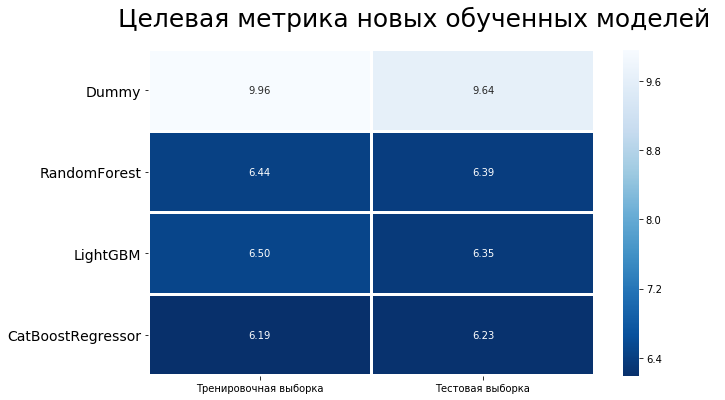

In [92]:
all_metrics_2 = {"Тренировочная выборка":pd.Series([dummy_mae_train_2, RandomForest_mae_train_2, LightGBM_mae_train_2, cross_val_catboost_2],
                                                 index=['Dummy', 'RandomForest', 'LightGBM', 'CatBoostRegressor']),
              "Тестовая выборка":pd.Series([dummy_mae_test_2, RandomForest_mae_test_2, LightGBM_mae_test_2, mae_test_cbr_2], index=['Dummy', 'RandomForest', 'LightGBM', 'CatBoostRegressor'])}

data_metrics_2 = pd.DataFrame(all_metrics_2)

plt.figure(figsize=(10,6))
sns.heatmap(data_metrics_2,  annot=data_metrics_2, fmt='.2f', linewidths=2 , cmap="Blues_r")
plt.suptitle('Целевая метрика новых обученных моделей ', fontsize=25)
plt.yticks( rotation=0, fontsize=14)

Видим, что связь с удаленными признаками была самая высокая у CatBoostRegressor, что помогло сильно улучишть её качество и достигнуть показателей МАЕ 6.19 на тренировочной и 6.23 на тестовой выборке.

## Общий вывод

Лучший показатель целевой метрики был достигнут у CatBoostRegressor и равен 6.19 на тренировочной и 6.23 на тестовой выборке. Значение было достигнуто с использованием следующих признаков:

    Первый замер температуры
    Длительность плавления
    Полная температура
    Объем добавленной проволоки

Остальные признаки показали низкое влияние на качество модели при анализе их значимости. 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Александр, однозначно сильная работа!!!<br>
Я бы привёл ещё такие эпитеты: смелый, аналитический, вдумчивый проект.<br>
Правда, было интерсно погружать в твои рассуждения и следить  за ними.<br>
C позиции логики построения модели - мне всё понятно.<br>
    
Если говорить об очитске данных ещё: есть партии, которые начинались и заканчивались не измерением температуры а нагревом или засыпкой материала - это можно увидеть по времени, если разложить его на временной оси. И таких партий, по идее, надо избегать. Этот момент не обязательно было в проекте делать, НО лучше об этом помнить: всегда, кроме аномалий и пропусков - нужно проверять данные на адекватность данному бизнесу и данной задаче.<br>   
    
Также и теорией по электричеству: можно ли мощности суммировать? рекомендуют суммировать только работу. Но здесь это не критично. НО в реальных зазадачах - надо обязательно помнить, что могут быть вот такие "особенности" - т.е. нужно будет получить консультацию и других специалистов.<br>
 
Технически - очень добротная работа. <br>
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
<font color='green'>

Возмоно, что у тебя остались/ появились вопросы? У меня вот только про температуру плавления)

<div     style = 'color: #FFFFFF;
    background-color: #3E94C9;
    border-color: #d6e9c6; padding: 15px;
    margin-bottom: 18px;
    border: 1px solid transparent;
    border-radius: 2px;'>
<h2> Ответ исполнителя <a class="tocSkip"> </h2>

Немного не понял про температуру плавления) Там были сомнения выше, что сложно считывается информация по `длительность плавления` , а про температуру не видел вопроса. У длительности, думаю, стоит добавить в заголовке (сек.), чтобы заказчик мог понимать разрядность данных.
    
По поводу `есть партии, которые начинались и заканчивались не измерением температуры а нагревом или засыпкой материала - это можно увидеть по времени, если разложить его на временной оси.` - интересная информация, я об этом не подумал даже.
    
Хоть и МАЕ достаточно неплохой получился, меня всё же смущает, что мы отбрасываем так много данных, а если еще откинуть некорректные финальные или начальные замеры, то их и вовсе мало станет. До этого учили, что мы можем терять не более 10% данных. Как часто в реальности это будет происходить иначе? И нужно ли в таком случае просить у заказчика более крупные выборки, объясняя это возможной ростом ошибки предсказаний. Я просто тестирую для себя прогнозы на временных рядах и очень сильно заметил корреляцию роста качества модели с количеством объема данных. Из той зависимости что нашел - чем больше данных, тем более точный прогноз на длинной дистанции.
    
В остальном я прочитал, что нашел, по производственным процессам, но так и не смог для себя понять, почему газ и сыпучие материалы так плохо влияли на модель. Возможно, если бы мы знали более точные исходные данные: что плавим, что добавляем и т.д. , то можно было бы построить модель с большим количеством признаков и ошибка в предсказаниях снизилась еще больше. Сейчас могу только предположить, что влияние wire - материалов оказалось более значимым из-за обучаемых данных. Есть подозрения, что модель может ошибаться на других сплавах, а значит нужно еще какую нибудь первичную классификацию делать...Но у нас такого сейчас нет, просто лежал думал над этим) 
    
Сократить время работы очень сильно помогло общение с ТЛ. Обсудили технологические процессы, что можно \ что лучше не брать и сразу как по маслу поехало :)
    
И еще вопросик, возможно у вас есть какой нибудь интересный видео-материал того, что происходит с моделью после её реализации? Как её внедряют в систему? Мне ТЛ скинул крутую ссылку на гит, но я продолжаю искать в видео-формате. У меня жена очень хочет посмотреть как это всё потом...)))
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u>
<font color='green'><br>Привет, Александр!<br>
Точно, не температура) Извини. ОК, предложение добавить секунды - рабочее)<br>

По твоему вопросу о точности:<br>
Когда мы говорим о много/мало данных, например для линейной регрессии, то тут критерий такой: На один фатор влияния должно быть не менее 10-20 строк наблюдений. Т.е. если у нас 10 факторов, то строк должно быть не менн 100-200. В нашем случае 20 факторов, скажем. Значит строк - не менее 400. А остальное - запас) Почему так? это связано с расчётом коэффициентов модели. Грубо говоря, (когда 20 строк на один фактор) - мы расчитываем это коэффициент по 20-и значениям. А из начальной статистики знаем, чем больше данных, тем точнее среднее. С более сложными моделями - чуть иначе. Там сама математика требует большого количества данных, что заложенный мат.аппарат сработал. И если возвращаться к вопросу: сколько данных урезать? Самое главное - здравый смысл всегда!!! И риски, которые мы несём, отдавая решение. Если чувствуем/доказали/увидели, что данные неадекватные и с ними нельзя считаться, то смело режем. А уже с оставшиемся работаем, как можем. Зато всё будет "по чеснаку"))) ВО главе угла - достижение эффектвиности для закзачика. А если ему выгодно, то т нам честь и хвала))<br>
А с временными рядами - там ещё интреснее. Там надо опираться на горизонт прогноза. Если прогноз нужен на день вперёд. То, положа руку на сердце, нам достаточно 5-6 недель данных. (чем больше тем лучше, конечно же).. Но, боюсь, времени нет для этой темы сейчас(<br>
    
Про влияние газа и сыпучих материалов:<br>
Тут лучше так сказать: на текущих данных влияние газа и сыпучих - не высокое. Другими словами - влияяние первой температуры на столько сильное, что "гасит" иные факторы. А если убрать превую температуру - там может всё поменяться. А если ещё данные по хим.составу дадут (это к твоим размышлениям в догунку)) - там и заиграют другой "марш" все:))<br>
    
Эх, видео нет у меня(((<br>
Такие же вещи, как правило, позволяют изменять процесс управления в компании, в системе и т.д. Эти изменения отражаются в корректировке инструкций, технологических регламентов, сценариев работы и т.д. Т.е. так видео-то и не заснять...<br>
    
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>